In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tensorflow as tf
from utils import create_generators, build_model
from models_config import MODELS, INPUT_SIZES
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping


os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]='0' # Select the GPU to use

gpus = tf.config.list_physical_devices('GPU') # Use only the required GPU memory
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)


2024-05-21 11:27:26.398275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
DATASET = './dataset'  # path to the dataset
SPLITTED_DATASET = DATASET+'_splitted'
DEST_PATH = './trained_models'
LOG_PATH = './logs'
CLASS_NAMES = np.array([item for item in os.listdir(DATASET) if os.path.isdir(os.path.join(DATASET, item))])
NUM_CLASSES = len(CLASS_NAMES)
EPOCHS=20
BATCH_SIZE = 32  # size of the readed batches from generator
VAL_SPLIT = 0.15  # fraction of the images used for validation
TEST_SPLIT = 0.15  # fraction of the images used for testing

In [3]:
# Generate the splitted dataset from the original if it's not done
if not os.path.exists(SPLITTED_DATASET):
    import splitfolders # !pip install pip install split-folders
    splitfolders.ratio(DATASET, seed=123, output=SPLITTED_DATASET, ratio=(1-VAL_SPLIT-TEST_SPLIT, VAL_SPLIT, TEST_SPLIT))

os.makedirs(DEST_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)


evaluation_results = []

# Iterate over each model in the configuration
for model_name, (model_fn, preprocess_input) in MODELS.items():
    SIZES = INPUT_SIZES[model_name]
    for SIZE in SIZES:
        print("\n\n-------------------------------------------------------------------------\n")
        print(f"TRAINING MODEL: {model_name} WITH SIZE: {SIZE}")
        
        print("\nLoading images...")
        train_generator, validation_generator, test_generator = create_generators(preprocess_input, SPLITTED_DATASET, BATCH_SIZE, SIZE, n_plots=0)
        
        print("\nBuilding model...")
        model = build_model(model_fn, (SIZE, SIZE, 3), NUM_CLASSES)
        
        # Define callbacks
        csv_logger = CSVLogger(f'{LOG_PATH}/{model_name}_{SIZE}_training_log.csv', append=True)
        early_stop = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.01, restore_best_weights=True)

        print("\nTraining model...")
        history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            callbacks=[csv_logger, early_stop]
        )
        
        # Save the final model
        model.save(f'{DEST_PATH}/{model_name}_{SIZE}.keras')

        print("\nTesting model...")
        start_time = time.time()
        scores = model.evaluate(test_generator)
        test_time = time.time() - start_time

        for name, value in zip(model.metrics_names, scores):
            evaluation_results.append({
                            'Model': model_name,
                            'Size': SIZE,
                            'Metric': name,
                            'Value': value,
                        })

        # Add evaluation time as a metric
        evaluation_results.append({
            'Model': model_name,
            'Size': SIZE,
            'Metric': 'test_time',
            'Value': test_time,
        })


# Save evaluation results
df_results = pd.DataFrame(evaluation_results)
df_results.to_csv(f'{LOG_PATH}/test_results.csv', index=False)



-------------------------------------------------------------------------

TRAINING MODEL: mobilenet_v2 WITH SIZE: 32

Loading images...
Loading train data
Found 2796 images belonging to 4 classes.
Loading validation data
Found 597 images belonging to 4 classes.
Loading test data
Found 604 images belonging to 4 classes.
Images shape: (32, 32, 32, 3)

Building model...


2024-05-21 01:34:43.210562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30979 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0



Training model...
Epoch 1/20


2024-05-21 01:34:50.817796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-05-21 01:34:53.228391: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9a68017030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 01:34:53.228477: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-05-21 01:34:53.271076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-21 01:34:53.871760: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 [==============================] - 145s 2s/step - loss: 1.3123 - accuracy: 0.3923 - precision: 0.9070 - recall: 0.0139 - auc: 0.6794 - val_loss: 1.2234 - val_accuracy: 0.4824 - val_precision: 0.8333 - val_recall: 0.0503 - val_auc: 0.7632
Epoch 2/20
88/88 [==============================] - 137s 2s/step - loss: 1.1667 - accuracy: 0.5114 - precision: 0.7934 - recall: 0.1030 - auc: 0.7755 - val_loss: 1.1117 - val_accuracy: 0.5662 - val_precision: 0.8087 - val_recall: 0.1558 - val_auc: 0.7972
Epoch 3/20
88/88 [==============================] - 137s 2s/step - loss: 1.0948 - accuracy: 0.5336 - precision: 0.7372 - recall: 0.1695 - auc: 0.7931 - val_loss: 1.0636 - val_accuracy: 0.5729 - val_precision: 0.8010 - val_recall: 0.2630 - val_auc: 0.8084
Epoch 4/20
88/88 [==============================] - 136s 2s/step - loss: 1.0597 - accuracy: 0.5486 - precision: 0.7140 - recall: 0.2321 - auc: 0.8028 - val_loss: 1.0415 - val_accuracy: 0.5528 - val_precision: 0.7910 - val_recall: 0.3233 - val_auc

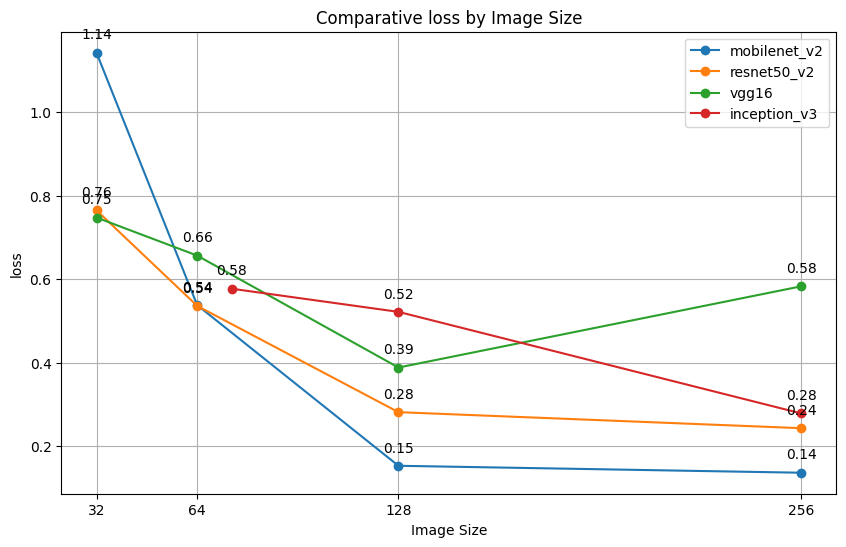

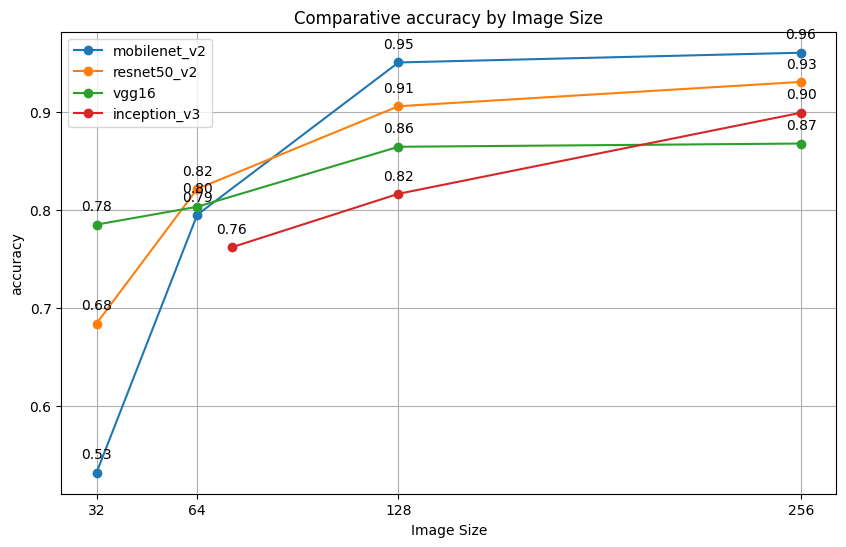

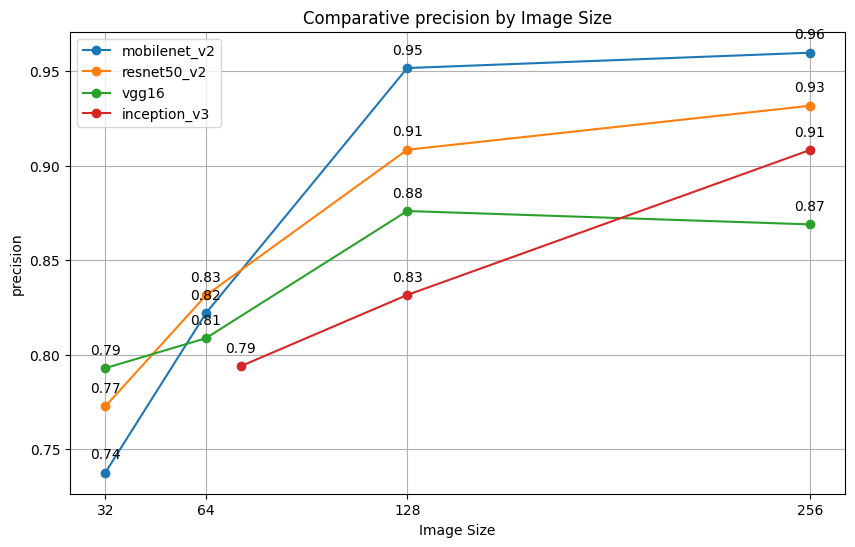

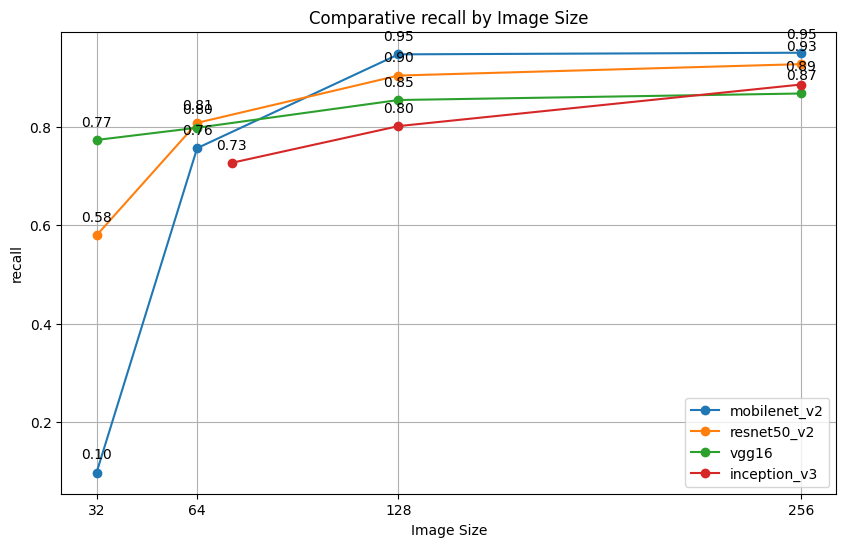

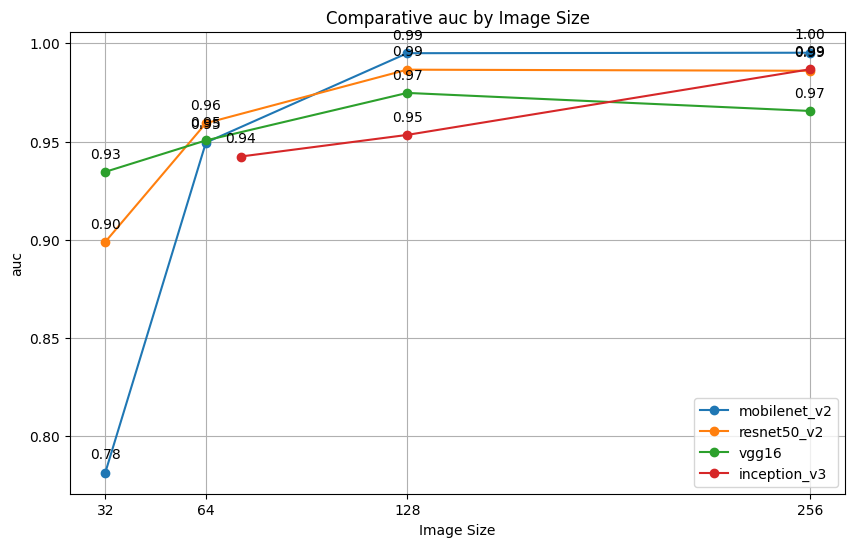

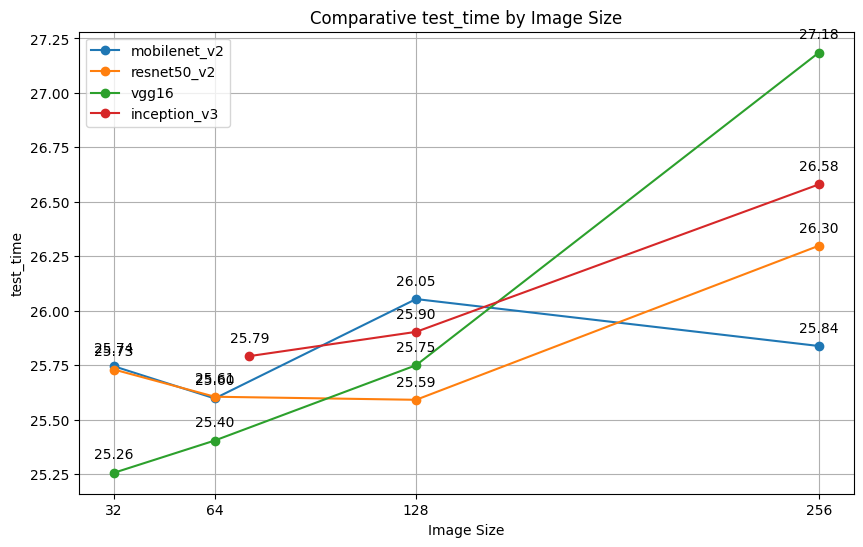

In [12]:
# Plot evaluation results

PLOT_PATH = './plots'
os.makedirs(PLOT_PATH, exist_ok=True)

# Reload results in case kernel is restarted
df_results = pd.read_csv(f'{LOG_PATH}/test_results.csv')

for metric in df_results['Metric'].unique():
    plt.figure(figsize=(10, 6))
    for model_name in df_results['Model'].unique():
        subset = df_results[(df_results['Model'] == model_name) & (df_results['Metric'] == metric)]
        plt.plot(subset['Size'], subset['Value'], marker='o', label=model_name)
        
        for i, row in subset.iterrows():
            plt.annotate(f'{row["Value"]:.2f}', (row['Size'], row['Value']), textcoords="offset points", xytext=(0,10), ha='center')
    
    
    plt.title(f'Comparative {metric} by Image Size')
    plt.xlabel('Image Size')
    plt.xticks([32, 64, 128, 256])
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{PLOT_PATH}/comparison_{metric}.png')
    plt.show()